# Navier Stokes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
import time

from scipy import io
from matplotlib import cm

from RF import *

## High resolution and high data

In [2]:
# Get Data

Inputs = np.load('NavierStokes_inputs.npy')
Outputs = np.load('NavierStokes_outputs.npy')

# transpose it and then it is easy to reshape

Inputs = Inputs.transpose((2,1,0))
Outputs = Outputs.transpose((2,1,0))

# flatten it

Inputs_fl = Inputs.reshape(len(Inputs), 64*64)
Outputs_fl = Outputs.reshape(len(Outputs), 64*64)


# train_test split
Ntrain = 10000
x_train = Inputs_fl[:Ntrain]
x_test = Inputs_fl[Ntrain:]

y_train = Outputs_fl[:Ntrain]
y_test = Outputs_fl[Ntrain:]

# check shape
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 4096), (10000, 4096), (30000, 4096), (30000, 4096))

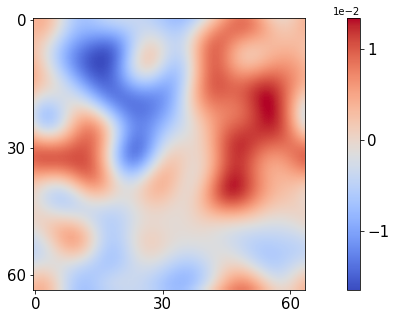

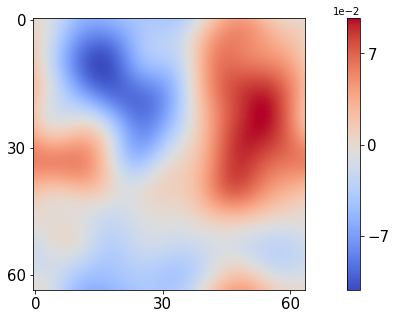

In [9]:
# Visualization of training pairs
idx = 1

# training input
fig, ax = plt.subplots(1,1, figsize=(15,5))
im = ax.imshow(x_train[idx].reshape(64,64), interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
plt.xticks([0,30,60], fontsize=15)
plt.yticks([0,30,60],fontsize=15)
cbar = fig.colorbar(im, ax=ax, ticks=[-0.01,0,0.01])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=15)
plt.savefig('NS_input.pdf', bbox_inches = 'tight')

# training output
fig, ax = plt.subplots(1,1, figsize=(15,5))
im = ax.imshow(y_train[idx].reshape(64,64), interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
plt.xticks([0,30,60],fontsize=15)
plt.yticks([0,30,60],fontsize=15)
cbar = fig.colorbar(im, ax=ax, ticks=[-0.07,0,0.07])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=15)
plt.savefig('NS_output.pdf', bbox_inches = 'tight')

In [10]:
############################# Cauchy random feature
# number of features
N = 10000
# scaling parameter gamma
gamma = 1e-4
# generate random feature matrix
x_train_RF, x_test_RF = RF_Cauchy(gamma, N, x_train, x_test)
# train a linear regression model
model = Ridge(alpha=1e-12)
start = time.time()
model.fit(x_train_RF, y_train)
pred = model.predict(x_test_RF)
end = time.time()
# report relative prediction error and clock time
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
print(f'Test error of Cauchy random feature model is {e}.\n')
print(f'Clock time is {end-start} seconds')

Test error of Cauchy random feature model is 0.007579132030816392.

Clock time is 24.915823698043823 seconds


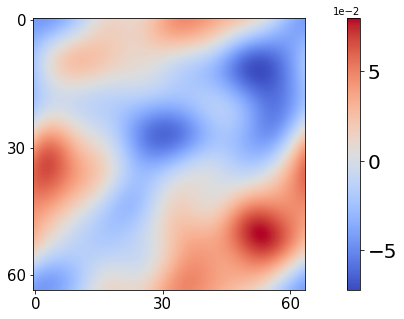

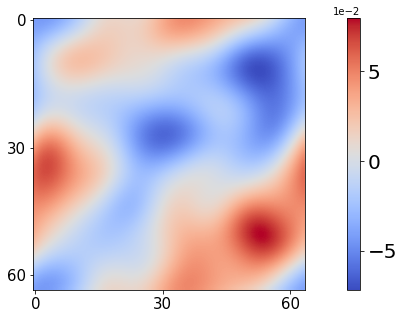

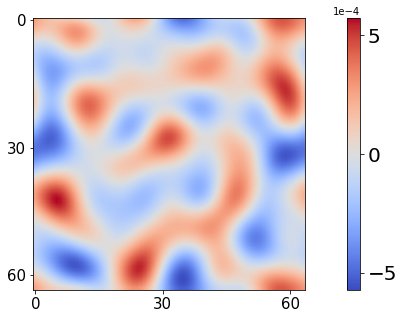

In [13]:
# Visualize the random feature prediction.
idx = 1

test = y_test[idx].reshape(64,64)
prediction = pred[idx].reshape(64,64)
error = prediction - test

# test
fig, ax = plt.subplots(1,1, figsize=(15,5))
im = ax.imshow(test, interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
plt.xticks([0,30,60],fontsize=15)
plt.yticks([0,30,60],fontsize=15)
cbar = fig.colorbar(im, ax=ax, ticks=[-0.05,0,0.05])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
plt.savefig('NS_test.pdf', bbox_inches = 'tight')

# prediction
fig, ax = plt.subplots(1,1, figsize=(15,5))
im = ax.imshow(prediction, interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
plt.xticks([0,30,60],fontsize=15)
plt.yticks([0,30,60],fontsize=15)
cbar = fig.colorbar(im, ax=ax, ticks=[-0.05,0,0.05])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
plt.savefig('NS_prediction.pdf', bbox_inches = 'tight')

# pointwise error
fig, ax = plt.subplots(1,1, figsize=(15,5))
im = ax.imshow(error, interpolation='bilinear', cmap= "coolwarm")
plt.grid(visible=False)
plt.xticks([0,30,60],fontsize=15)
plt.yticks([0,30,60],fontsize=15)
cbar = fig.colorbar(im, ax=ax, ticks=[-0.0005,0,0.0005])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
plt.savefig('NS_error.pdf', bbox_inches = 'tight')

In [21]:
########################### Gaussian random feature
from sklearn.kernel_approximation import RBFSampler


rbf_feature = RBFSampler(gamma=1e-3, n_components=20000)
x_train_RBF = rbf_feature.fit_transform(x_train)
x_test_RBF = rbf_feature.transform(x_test)

model = Ridge(alpha=1e-12)
start = time.time()
model.fit(x_train_RBF, y_train)
end = time.time()
pred = model.predict(x_test_RBF)

e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Test error is {e}.\n')
print(f'Computation time is {end-start} seconds.')

Test error is 0.00497093602057773.

Computation time is 23.919227838516235 seconds.


## Low resolution and low data regime:

In [21]:
# Get Data

Inputs = np.load('NavierStokes_inputs.npy')
Outputs = np.load('NavierStokes_outputs.npy')

# transpose it and then it is easy to reshape

Inputs = Inputs.transpose((2,1,0))
Outputs = Outputs.transpose((2,1,0))

# subsampling
Inputs = Inputs[:,::4,::4]
Outputs = Outputs[:,::4,::4]


# flatten it
Inputs_fl = Inputs.reshape(len(Inputs), 16*16)
Outputs_fl = Outputs.reshape(len(Outputs), 16*16)


# train_test split
Ntrain = 2000
x_train = Inputs_fl[:Ntrain]
x_test = Inputs_fl[Ntrain:2*Ntrain]

y_train = Outputs_fl[:Ntrain]
y_test = Outputs_fl[Ntrain:2*Ntrain]

# check shape
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2000, 256), (2000, 256), (2000, 256), (2000, 256))

In [68]:
############################# Cauchy random feature
# number of features
N = 10000
# scaling parameter gamma
gamma = 1e-3
# generate random feature matrix
x_train_RF, x_test_RF = RF_Cauchy(gamma, N, x_train, x_test)
# train a linear regression model
model = Ridge(alpha=1e-10)
start = time.time()
model.fit(x_train_RF, y_train)
pred = model.predict(x_test_RF)
end = time.time()
# report relative prediction error and clock time
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
print(f'Test error of Cauchy random feature model is {e:.2e}.\n')
print(f'Clock time is {end-start:.2f} seconds')

Test error of Cauchy random feature model is 3.21e-02.

Clock time is 0.46 seconds


In [39]:
########################### Gaussian random feature
from sklearn.kernel_approximation import RBFSampler


rbf_feature = RBFSampler(gamma=0.5, n_components=50000)
x_train_RBF = rbf_feature.fit_transform(x_train)
x_test_RBF = rbf_feature.transform(x_test)

model = Ridge(alpha=1e-10)
start = time.time()
model.fit(x_train_RBF, y_train)
end = time.time()
pred = model.predict(x_test_RBF)

e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Test error is {e:.2e}.\n')
print(f'Computation time is {end-start:.2f} seconds.')

Test error is 1.06e-02.

Computation time is 1.87 seconds.


In [28]:
####################################### Gaussian kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

bandwidth = 1
kernel = RBF(length_scale = bandwidth)
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

start = time.time()
model.fit(x_train, y_train)
end = time.time()
pred = model.predict(x_test)

e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Error is {e:.2e}. \n')
print(f'Computation time is {end-start:.2f} seconds')

Error is 1.09e-02. 

Computation time is 292.07 seconds


In [30]:
##################### Matern kernel
kernel = Matern(nu = 2.5, length_scale = 1)
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

start = time.time()
model.fit(x_train, y_train)
end = time.time()
pred = model.predict(x_test)

e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(f'Error is {e:.2e}. \n')
print(f'Computation time is {end-start:.2f} seconds')

Error is 9.08e-03. 

Computation time is 172.23 seconds
